# Proyecto 04 - Redes Neuronales

## - Objetivo

Para este proyecto, como **desafío** se intentarán mejorar los resultados del modelo de <i>Machine Learning</i> empleado en el Proyecto 3, en su versión binaria, medinate el uso de Redes Neuronales.

## - Preliminares

Importemos las librerías que requeriremos para este proyecto.

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import spacy

import es_core_news_lg

from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish

from spacy.lemmatizer import Lemmatizer

import string

from spacy.lookups import Lookups

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import LinearSVC

import keras as keras

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from keras.regularizers import l2

from keras.layers import Dropout

from keras.models import Sequential
from keras.models import load_model

from plot_keras_history import plot_history

import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from keras.optimizers import Adam
from keras.optimizers import SGD

import gc

from numpy.random import seed

Using TensorFlow backend.


Ahora, importemos como <i>DataFrames</i> los <i>datasets</i> que utilizaremos y, para darnos una idea de cómo son, imprimamos sus primeros cinco registros.

In [2]:
dataset_train = pd.read_json('dataset_es_train.json', lines = True)
dataset_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [3]:
dataset_dev = pd.read_json('dataset_es_dev.json', lines = True)
dataset_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [4]:
dataset_test = pd.read_json('dataset_es_test.json', lines = True)
dataset_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase


Dado que en el Proyecto anterior, que se puede consultar [aquí](https://github.com/Pozzo740/Acamica_Projects), se hizo el Análisis Exploratorio de Datos para estos <i>datasets</i> omitiremos este análisis en su mayoría, realizando de nuevo únicamente aquello que será relevante para este proyecto.

De los <i>DataFrames</i> anteriores hay variables que no utilizaremos. Las eliminaremos a fin de trabajar con datos más limpios.

Por otro lado, en el proyecto anterior vimos que juntar en una sola a las variables `review_body` y `review_title` es con la que nuestro modelo, tanto en el caso multi clase como en el binario, predice mejor nuestra variable objetivo. Así es que nueveamente las juntaremos, llamándola `review_body_title` y posteriormente eliminiaremos también las dos variables que la originaron pues no las necesitaremos más.

Finalmente, dado que es la versión binaria la que trabajaremos, crearemos la que será nuestra variable objetivo, `sentiment`, la cual tomará valores como sigue: todos los valores de `review_body_title` que tengan 1, 2 ó 3 estrellas tendrán asignado el valor <i><b>negative</b></i> en `sentiment` y el resto, es decir, los valores de `review_body_title` que tengan 4 ó 5 estrellas tendrán asignado el valor <i><b>positive</b></i>.

Hagamos estos cambios e imprimamos en pantalla los primeros cinco registros para visualizar cómo serán nuestros nuevos <i>DataFrames</i>.

In [5]:
df_train = dataset_train.drop(['review_id', 'product_id', 'reviewer_id', 'language',
                               'product_category'], axis = 1)
df_train_comb = df_train.copy()
df_train_comb['review_body_title'] = df_train_comb['review_body'] + ' ' + df_train_comb['review_title']
del df_train_comb['review_body']
del df_train_comb['review_title']
df_train_comb['sentiment'] = df_train_comb.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_train_comb.head()

,stars,review_body_title,sentiment
0,1,Nada bueno se me fue ka pantalla en menos de 8...,negative
1,1,"Horrible, nos tuvimos que comprar otro porque ...",negative
2,1,Te obligan a comprar dos unidades y te llega s...,negative
3,1,"No entro en descalificar al vendedor, solo pue...",negative
4,1,Llega tarde y co la talla equivocada Devuelto,negative


In [6]:
df_dev = dataset_dev.drop(['review_id', 'product_id', 'reviewer_id', 'language',
                               'product_category'], axis = 1)
df_dev_comb = df_dev.copy()
df_dev_comb['review_body_title'] = df_dev_comb['review_body'] + ' ' + df_dev_comb['review_title']
del df_dev_comb['review_body']
del df_dev_comb['review_title']
df_dev_comb['sentiment'] = df_dev_comb.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_dev_comb.head()

,stars,review_body_title,sentiment
0,1,"Malisimo, muy grande demasiado aparatoso y mal...",negative
1,1,No he recibido el pedido no la devolución No l...,negative
2,1,"Tengo que buscar otro sistema, este no funcion...",negative
3,1,Utilicé las brocas de menor diámetro y se me d...,negative
4,1,No me gusta su olor a viejo y aspecto malo No ...,negative


In [7]:
df_test = dataset_test.drop(['review_id', 'product_id', 'reviewer_id', 'language',
                               'product_category'], axis = 1)
df_test_comb = df_test.copy()
df_test_comb['review_body_title'] = df_test_comb['review_body'] + ' ' + df_test_comb['review_title']
del df_test_comb['review_body']
del df_test_comb['review_title']
df_test_comb['sentiment'] = df_test_comb.stars.apply(lambda x: 'negative' if x in [1, 2, 3] else 'positive')
df_test_comb.head()

,stars,review_body_title,sentiment
0,1,no me llego el articulo me lo mando por correo...,negative
1,1,"la mensajería horrible, no compro mas amazon s...",negative
2,1,Estoy muy decepcionado con el vendedor ya que ...,negative
3,1,Mi valoración no es sobre el producto sino sob...,negative
4,1,Pues tenía interés en este libro y probé la ve...,negative


A continuación, instanciaremos nuestro modelo de `spaCy`.

In [8]:
nlp = es_core_news_lg.load()

Ahora, definimos la siguiente función para normalizar los valores de nuestra variable `review_body_title` y la aplicamos para los tres <i>DataFrames</i>.

In [9]:
def normalize(comment, lowercase, remove_stopwords):
    punctuations = string.punctuation
    stops = spacy.lang.es.stop_words.STOP_WORDS
    non_stops = ['no', 'sí', 'si', 'bueno', 'buenos', 'buena', 'buenas', 'buen', 'mal',
                 'nada', 'nunca', 'siempre', 'mejor', 'demasiado', 'peor', 'muy', 'más',
                 'mas', 'bien', 'bastante', 'estado', 'mucho', 'muchos']
    otros = ['a', 'e', 'o', 'u', 'q', 'y', 'para', 'pare', 'paro', 'como', '..', '...',
             '....', '.....', '......', '.......', '........', '.........', '¡', '¿']
    letters = list(string.ascii_lowercase) + ['á', 'é', 'í', 'ó', 'ú', 'ü', 'ch', 'ñ']
    list_2 = []
    
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        if word.text not in non_stops:
            if not remove_stopwords or (remove_stopwords and word.text not in stops):
                if word.text not in punctuations:
                    if word.text not in otros:
                        lemma = word.lemma_.strip()
                        lemmatized.append(lemma)
        elif word.text in non_stops:
            lemma = word.lemma_.strip()
            lemmatized.append(lemma)
    for token in lemmatized:
        for ch in token:
            if ch not in letters:
                list_2.append(token)
    for w in list_2:
        if w in lemmatized:
            lemmatized.remove(w)                
    return " ".join(lemmatized)

In [10]:
df_train_comb['review_body_title'] = df_train_comb['review_body_title'].apply(normalize, lowercase = True, remove_stopwords = True)
df_dev_comb['review_body_title'] = df_dev_comb['review_body_title'].apply(normalize, lowercase = True, remove_stopwords = True)
df_test_comb['review_body_title'] = df_test_comb['review_body_title'].apply(normalize, lowercase = True, remove_stopwords = True)

Miremos cómo quedó nuestra variable objetivo ya normalizada.

In [11]:
df_train_comb.tail()

,stars,review_body_title,sentiment
199995,5,mandar funcionar perfectamente cumplir funcion...,positive
199996,5,comprar batería reticencia resultar muy fácil ...,positive
199997,5,bueno calidad satisfacer comprar bueno calidad,positive
199998,5,perfecto cumplir hijo recomendar,positive
199999,5,súper bien brocha bueno no caer pelitos pesar ...,positive


In [12]:
df_dev_comb.tail()

,stars,review_body_title,sentiment
4995,5,encantar cesta llegar tamaño muy util no pesar...,positive
4996,5,desempeñar función correctamente calidad preciar,positive
4997,5,encantar diadema flor venir imagen no venir ap...,positive
4998,5,gustar mucho fundir tpu fundir normalmente fin...,positive
4999,5,artículo cumplir expectativa desear bueno calidad,positive


In [13]:
df_test_comb.tail()

,stars,review_body_title,sentiment
4995,5,costar perfecto cumplir función sobrar pecar c...,positive
4996,5,material muy flexible cómodo acorde descripció...,positive
4997,5,ver bien grabar medalla bonito grabar,positive
4998,5,comprar bici finalmente quedar xiaomi scooter ...,positive
4999,5,tipo casco si inalambricos no atar goma tipica...,positive


In [14]:
gc.collect()

120

Veamos ahora si tenemos valores faltantes y cómo está balanceada nuestra variable objetivo en cada uno de los *datasets*.

In [15]:
df_train_comb.isna().sum()

stars                0
review_body_title    0
sentiment            0
dtype: int64

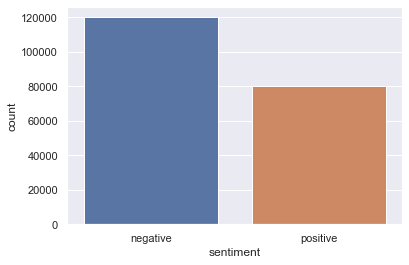

In [16]:
sns.countplot(df_train_comb.sentiment)
plt.show()

In [17]:
df_dev_comb.isna().sum()

stars                0
review_body_title    0
sentiment            0
dtype: int64

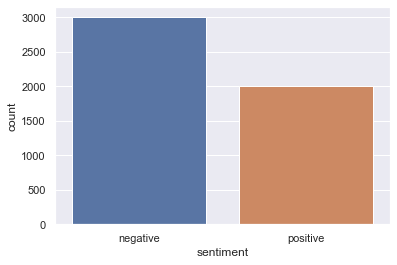

In [18]:
sns.countplot(df_dev_comb.sentiment)
plt.show()

In [19]:
df_test_comb.isna().sum()

stars                0
review_body_title    0
sentiment            0
dtype: int64

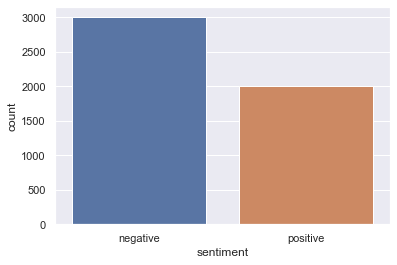

In [20]:
sns.countplot(df_test_comb.sentiment)
plt.show()

En los tres *datasets* tenemos una relación de sentimientos positivos/negativos de 60/40. Esta proporción todavía puede considerarse balanceada por lo que el *accuracy* sigue siendo una buena métrica.

## - Modelos de <i>Machine Learning</i>

Para esta parte, comenzamos definiendo el que será nuestro modelo <i>benchmark</i> el cual será el que mejores resultados nos dio en el proyecto anterior, esto es, `LinearSVC`.

### - Modelo <i>benchmark</i>

En el proyecto anterior, encontramos que el mejor número de <i>features</i> para el modelo `LinearSVC` en la versión binaria fue de cinco mil. Así, esa es la cantidad que usaremos para él en este caso también.

Ejecutaremos un `GridSearchCV` para encontrar los mejores hiperparámetros para nuestro modelo y, con ellos, correremos nuestro modelo sobre el <i>dataset test</i>.

In [21]:
list_review_body_title_train = list(df_train_comb['review_body_title'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_review_body_title_train = vectorizer.fit_transform(list_review_body_title_train)
X_train = vect_review_body_title_train.toarray()
y_train = df_train_comb['sentiment'].values

svc = LinearSVC(dual = False, random_state = 42)

param_grid = {'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge'],
              'tol': [1e-3, 1e-2, 1e-1], 'C': [1e-2, 1e-1, 1],
              'fit_intercept': [False, True]}

svc_gs = GridSearchCV(estimator = svc, param_grid = param_grid, scoring = 'accuracy', cv = 5)

svc_gs.fit(X_train, y_train)

print('The best parameters are:', svc_gs.best_params_, '\n')
print('The best accuracy is:', svc_gs.best_score_)

The best parameters are: {'C': 0.1, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.001} 

The best accuracy is: 0.852885


In [22]:
svc = LinearSVC(dual = False, penalty = svc_gs.best_params_['penalty'],
                loss = svc_gs.best_params_['loss'], tol = svc_gs.best_params_['tol'],
                C = svc_gs.best_params_['C'],
                fit_intercept = svc_gs.best_params_['fit_intercept'], random_state = 42)

list_review_body_title_train = list(df_train_comb['review_body_title'].values)
list_review_body_title_test = list(df_test_comb['review_body_title'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_review_body_title_train = vectorizer.fit_transform(list_review_body_title_train)
X_train = vect_review_body_title_train.toarray()
y_train = df_train_comb['sentiment'].values

svc.fit(X_train, y_train)

vect_review_body_title_test = vectorizer.transform(list_review_body_title_test)
X_test = vect_review_body_title_test.toarray()
y_test = df_test_comb['sentiment'].values

y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Train accuracy:', accuracy_score(y_train, y_train_pred))
print('Test accuracy:', accuracy_score(y_test, y_test_pred))

Train accuracy: 0.88053
Test accuracy: 0.8754


Definimos la siguiente función para evaluar matrices de confusión.

In [23]:
def confusion(ytest, y_pred):
    names = ['Negative', 'Positive']
    cm = confusion_matrix(ytest, y_pred)
    f, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cm, annot = True, linewidth = .5, linecolor = "r", fmt = ".0f", ax = ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names, rotation = 45)
    ax.set_yticklabels(names, rotation = 45)
    plt.show()

    return

Y ahora, miramos la matriz de confusión para nuestro modelo.

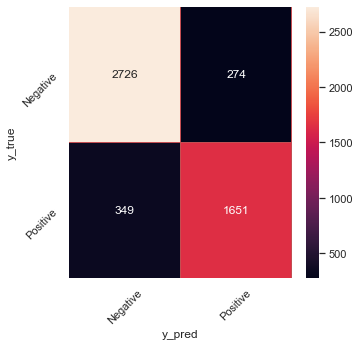

In [24]:
confusion(y_test, y_test_pred)

## - Concluisones

El modelo *benchmark* tiene un buen *accuracy* en general; sin embargo, el *accuracy* por etiqueta está desbalanceado: es de 82.55% para la etiqueta <b>*postitive*</b> y de 90.87% para la etiqueta <b>*negative*</b>.

In [25]:
gc.collect()

9825

## - <i>Neural Network</i>

Habiendo definido ya el <i>benchmark</i> pasemos ahora a nuestro modelo de redes neuronales.

Para que nuestro modelo de redes neuronales funcione, necesitamos aplicar *One-Hot Encoding* en nuestra variable `sentiment`.

In [26]:
one_hot_train = pd.get_dummies(df_train_comb['sentiment'])
df_train_comb = df_train_comb.join(one_hot_train)
df_train_comb

,stars,review_body_title,sentiment,negative,positive
0,1,nadar bueno ka pantalla mesar no recibir respu...,negative,1,0
1,1,horrible tener comprar inglés informático hora...,negative,1,0
2,1,obligar comprar unidad llegar no formar reclam...,negative,1,0
3,1,no entrar descalificar vendedor mesar esperar ...,negative,1,0
4,1,llegar co tallar equivocar devolver,negative,1,0
...,...,...,...,...,...
199995,5,mandar funcionar perfectamente cumplir funcion...,positive,0,1
199996,5,comprar batería reticencia resultar muy fácil ...,positive,0,1
199997,5,bueno calidad satisfacer comprar bueno calidad,positive,0,1
199998,5,perfecto cumplir hijo recomendar,positive,0,1


In [27]:
one_hot_dev = pd.get_dummies(df_dev_comb['sentiment'])
df_dev_comb = df_dev_comb.join(one_hot_dev)
df_dev_comb

,stars,review_body_title,sentiment,negative,positive
0,1,malisimo muy grande demasiar aparatoso mal pro...,negative,1,0
1,1,no recibir pedir no devolución no recibir,negative,1,0
2,1,buscar sistema no funcionar muy bien abrazader...,negative,1,0
3,1,utilizar broca menor diámetro doblar si ser ma...,negative,1,0
4,1,no gustar olor viejo aspecto malo no gustar,negative,1,0
...,...,...,...,...,...
4995,5,encantar cesta llegar tamaño muy util no pesar...,positive,0,1
4996,5,desempeñar función correctamente calidad preciar,positive,0,1
4997,5,encantar diadema flor venir imagen no venir ap...,positive,0,1
4998,5,gustar mucho fundir tpu fundir normalmente fin...,positive,0,1


In [28]:
one_hot_test = pd.get_dummies(df_test_comb['sentiment'])
df_test_comb = df_test_comb.join(one_hot_test)
df_test_comb

,stars,review_body_title,sentiment,negative,positive
0,1,no llegar articular mandar correo normal segui...,negative,1,0
1,1,mensajería horrible no comprar mas amazon cump...,negative,1,0
2,1,muy decepcionar vendedor pedir no no cumplir p...,negative,1,0
3,1,valoración no producto amazon ofrecer producto...,negative,1,0
4,1,interés librar probar versión kindle abrir por...,negative,1,0
...,...,...,...,...,...
4995,5,costar perfecto cumplir función sobrar pecar c...,positive,0,1
4996,5,material muy flexible cómodo acorde descripció...,positive,0,1
4997,5,ver bien grabar medalla bonito grabar,positive,0,1
4998,5,comprar bici finalmente quedar xiaomi scooter ...,positive,0,1


Para comenzar, definimos nuestros conjuntos de entrenamiento y prueba.

In [29]:
list_review_body_title_train = list(df_train_comb['review_body_title'].values)
list_review_body_title_dev = list(df_dev_comb['review_body_title'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_review_body_title_train = vectorizer.fit_transform(list_review_body_title_train)
X_train = vect_review_body_title_train.toarray()
y_train = df_train_comb.iloc[:, 4]

vect_review_body_title_dev = vectorizer.transform(list_review_body_title_dev)
X_test = vect_review_body_title_dev.toarray()
y_test = df_dev_comb.iloc[:, 4]

Creamos una semilla, para tener consistencia de resultados si la red se corre nuevamente.

In [30]:
the_seed = 42

seed(the_seed)
tf.random.set_random_seed(the_seed)

A continuación, escalamos nuestros datos (de la bibliografía consultada, se desprende que para problemas de clasificación no es imperiso; sin embargo, siempre es una buen práctica).

In [31]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Definimos el `input_dim`, instanciamos el modelo y definimos sus capas.

**Nota:** Se probaron diferentes redes, jugando principalmente con:

- El número de capas .
- El número de nodos en las capas ocultas (de la bibliografía electrónica consultada se desprende que una buena distribución de los nodos es tomar en la capa oculta correspondiente la mitad de los de la capa inmediata anterior).
- Las regularizaciones (entre ellas, `dropout`).
- El optimizador (se probaron `adam` y `sgd`).
- Los hiperparámetros `learning_rate`, `epochs` y `batch_size`.
- Además, se probaron las redes con y sin <b>*EarlyStopping*</b> y <b>*MonitorCheckpoint*</b>. De estos últimos, se jugó con los hiperparámetros `pacience` y `monitor` (se probó con `val_accuracy` y con `val_loss`).

Para fines de reporte y practicidad (hubo redes que tardaron más de 22 horas en entrenarse), se deja únicamente la red que de entre todas las anteriores se desempeñó mejor en este conjunto *dev*.

In [32]:
input_dim = X_train.shape[1]

model = Sequential()

model.add(layers.Dense(5000, input_dim = input_dim, kernel_regularizer = l2(0.001),
                       activation = 'relu'))
model.add(layers.Dense(2500, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(1250, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(625, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(312, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(156, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(78, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(39, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(20, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(10, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(5, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(2, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

Definimos ahora el optimizador que usaremos así como algunos hiperparámetros.

In [33]:
optimizer = keras.optimizers.SGD(lr = 0.005)

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5000)              25005000  
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              12502500  
_________________________________________________________________
dense_3 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
dense_4 (Dense)              (None, 625)               781875    
_________________________________________________________________
dense_5 (Dense)              (None, 312)               195312    
_________________________________________________________________
dense_6 (Dense)              (None, 156)               48828     
__________________________

In [34]:
my_callbacks = [
EarlyStopping(patience = 10, monitor = 'val_accuracy'),
ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True)
]

history_dev = model.fit(X_train_scaled, y_train, epochs = 100, verbose = False,
                    validation_data = (X_test_scaled, y_test), callbacks = my_callbacks, batch_size = 64).history

Instanciamos al mejor modelo encontrado e imprimimos los *accuracys* en *train* y *test* así como la pérdida en cada uno.

In [35]:
best_model = load_model('best_model.h5')

train_acc = best_model.evaluate(X_train_scaled, y_train, verbose = 0)
print('Trainning loss:', train_acc[0])
print('Trainning accuracy:', train_acc[1], '\n')

test_acc = best_model.evaluate(X_test_scaled, y_test, verbose = 0)
print('Testing loss:', test_acc[0])
print('Testing accuracy:', test_acc[1])

Trainning loss: 5.136222505569458
Trainning accuracy: 0.9051849842071533 

Testing loss: 5.1939705528259275
Testing accuracy: 0.878600001335144


Ahora, graficamos tanto la función de pérdida como el *accuracy* durante los diferentes valores de `epochs`.

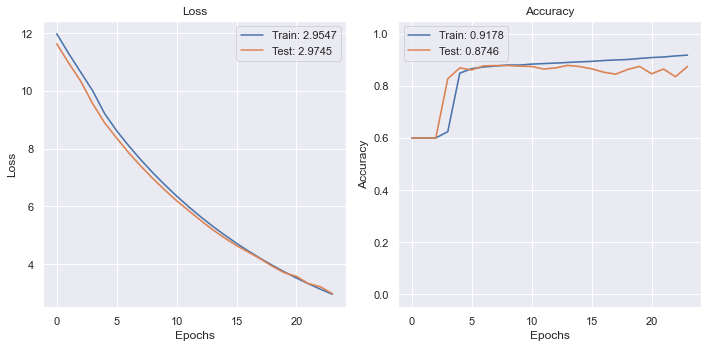

In [36]:
plot_history(history_dev)

Definimos ahora a `y_test`y a `y_pred_test`.

In [37]:
y_test = df_dev_comb.iloc[:, 4]
y_pred_test = best_model.predict_classes(X_test_scaled)

Ahora, definimos la siguiente función para graficar la matriz de confusión de la red y la usamos.

In [38]:
def confusion_net(ytest, y_pred):
    names = ['Negativo', 'Positivo']
    cm = confusion_matrix(ytest, y_pred)
    f, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(cm, annot = True, linewidth = .5, linecolor = "r", fmt = ".0f", ax = ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names, rotation = 45)
    ax.set_yticklabels(names, rotation = 45)
    plt.show()

    return

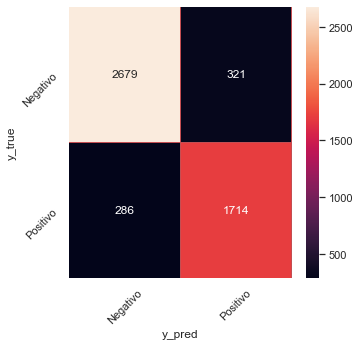

In [39]:
confusion_net(y_test, y_pred_test)

## - Conclusiones

El *accuracy* general de esta red en el conjunto *dev* es muy bueno; de hecho, aunque hasta las milésimas, mejor que el del modelo *benchmark*. Además, el balance del *accuracy* por etiqueta mejora sensiblemente respecto a este último: 85.7% para la etiqueta <b>*positive*</b> y 89.3% para <b>*negative*</b>.

A continuación, ya que tenemos nuestra red optimizada, veamos cómo predice en el *dataset test*.

Nuevamente, definimos nuestros conjuntos de entrenamiento y prueba.

In [40]:
list_review_body_title_train = list(df_train_comb['review_body_title'].values)
list_review_body_title_test = list(df_test_comb['review_body_title'].values)

vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000)
vect_review_body_title_train = vectorizer.fit_transform(list_review_body_title_train)
X_train = vect_review_body_title_train.toarray()
y_train = df_train_comb.iloc[:, 4]

vect_review_body_title_test = vectorizer.transform(list_review_body_title_test)
X_test = vect_review_body_title_test.toarray()
y_test = df_test_comb.iloc[:, 4]

Creamos una semilla, para tener consistencia de resultados si la red se corre nuevamente.

In [41]:
the_seed = 42

seed(the_seed)
tf.random.set_random_seed(the_seed)

A continuación, escalamos nuestros datos.

In [42]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y ahora, definimos nuevamente nuestro modelo y lo entrenamos.

In [43]:
input_dim = X_train.shape[1]

model = Sequential()

model.add(layers.Dense(5000, input_dim = input_dim, kernel_regularizer = l2(0.001),
                       activation = 'relu'))
model.add(layers.Dense(2500, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(1250, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(625, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(312, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(156, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(78, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(39, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(20, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(10, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(5, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(2, kernel_regularizer = l2(0.001), activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [44]:
optimizer = keras.optimizers.SGD(lr = 0.005)

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 5000)              25005000  
_________________________________________________________________
dense_15 (Dense)             (None, 2500)              12502500  
_________________________________________________________________
dense_16 (Dense)             (None, 1250)              3126250   
_________________________________________________________________
dense_17 (Dense)             (None, 625)               781875    
_________________________________________________________________
dense_18 (Dense)             (None, 312)               195312    
_________________________________________________________________
dense_19 (Dense)             (None, 156)               48828     
_________________________________________________________________
dense_20 (Dense)             (None, 78)               

In [45]:
my_callbacks = [
EarlyStopping(patience = 10, monitor = 'val_accuracy'),
ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True)
]

history_test = model.fit(X_train_scaled, y_train, epochs = 100, verbose = False,
                    validation_data = (X_test_scaled, y_test), callbacks = my_callbacks, batch_size = 64).history

Instanciamos al mejor modelo encontrado e imprimimos los *accuracys* en *train* y *test* así como la pérdida.

In [46]:
best_model = load_model('best_model.h5')

train_acc = best_model.evaluate(X_train_scaled, y_train, verbose = 0)
print('Trainning loss:', train_acc[0])
print('Trainning accuracy:', train_acc[1], '\n')

test_acc = best_model.evaluate(X_test_scaled, y_test, verbose = 0)
print('Testing loss:', test_acc[0])
print('Testing accuracy:', test_acc[1])

Trainning loss: 6.94115517112732
Trainning accuracy: 0.8898900151252747 

Testing loss: 6.968655892181396
Testing accuracy: 0.8762000203132629


Ahora, graficamos tanto la función de pérdida como el *accuracy* durante los diferentes valores de `epochs`.

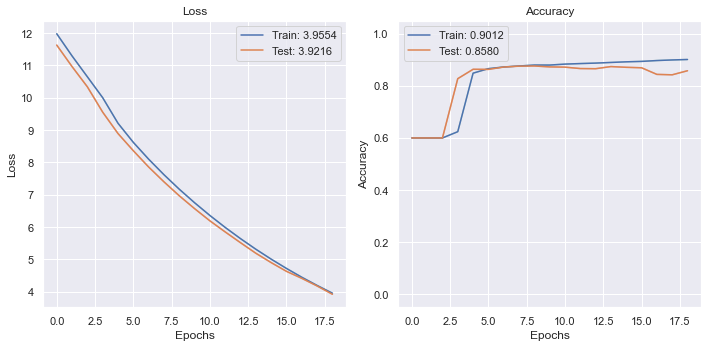

In [47]:
plot_history(history_test)

Definimos ahora a `y_test`y a `y_pred_test`.

In [48]:
y_test = df_test_comb.iloc[:, 4]
y_pred_test = best_model.predict_classes(X_test_scaled)

Y graficamos la matriz de confusión.

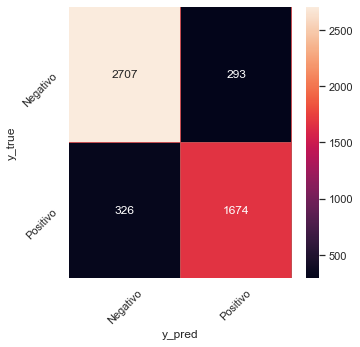

In [49]:
confusion_net(y_test, y_pred_test)

## - Conclusiones

Esta red en *test* tiene un *accuracy* prácticamente igual que en *dev*, el cual es muy bueno, y sigue siendo muy ligeramente superior al del modelo *becnhmark*.

Ahora bien, respecto al balance del *accuracy* por etiqueta, la red logró un 83.7% para la etiqueta <b>*positive*</b> y un 90.2% para <b>*negative*</b> por lo que también se logra una ligera reducción de la brecha entre ambos *accuracys* respecto al modelo *benchmark*.

Aun cuando el costo computacional de utilizar la red es superior al del *benchmark*, se considera que vale la pena tomando en cuenta las ganancias que se obtienen y que este costo no es mucho mayor al que representa el *benchmark*.

## - Bibliografía

A continuación, se deja la bibliografía electrónica que se utilizó.

- https://towardsdatascience.com/binary-classification-of-imdb-movie-reviews-648342bc70dd
- https://realpython.com/python-keras-text-classification/
- https://keras.io/api/optimizers/adam/
- https://keras.io/api/optimizers/sgd/
- https://keras.io/api/callbacks/early_stopping/
- https://keras.io/api/callbacks/
- https://github.com/late347/cognitive-systems-health-applications/blob/master/NeuralNetworks_case1_v1.ipynb
- https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization
- https://towardsdatascience.com/regularization-techniques-and-their-implementation-in-tensorflow-keras-c06e7551e709
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://medium.com/fintechexplained/what-are-hidden-layers-4f54f7328263